# Japanese Equity Data - Feature Engineering

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import talib

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')

In [4]:
idx = pd.IndexSlice

## Get Data

### Stooq Japanese Equity data 2014-2019

In [5]:
DATA_DIR = Path('..', 'data')

In [6]:
prices = (pd.read_hdf(DATA_DIR / 'assets.h5', 'stooq/jp/tse/stocks/prices')
          .loc[idx[:, '2010': '2019'], :])

In [7]:
prices.info(null_counts=True)    

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7533425 entries, ('1301.JP', Timestamp('2010-01-04 00:00:00')) to ('9997.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    7533425 non-null  float64
 1   high    7533425 non-null  float64
 2   low     7533425 non-null  float64
 3   close   7533425 non-null  float64
 4   volume  7533425 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 316.2+ MB


In [8]:
before = len(prices.index.unique('ticker').unique())

### Remove symbols with missing values

In [9]:
prices = (prices.unstack('ticker')
        .sort_index()
        .ffill(limit=5)
        .dropna(axis=1)
        .stack('ticker')
        .swaplevel())
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5608210 entries, ('1301.JP', Timestamp('2010-01-04 00:00:00')) to ('9997.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    5608210 non-null  float64
 1   high    5608210 non-null  float64
 2   low     5608210 non-null  float64
 3   close   5608210 non-null  float64
 4   volume  5608210 non-null  float64
dtypes: float64(5)
memory usage: 235.4+ MB


In [10]:
after = len(prices.index.unique('ticker').unique())
print(f'Before: {before:,.0f} after: {after:,.0f}')

Before: 3,685 after: 2,290


### Keep most traded symbols

In [11]:
dv = prices.close.mul(prices.volume)
keep = dv.groupby('ticker').median().nlargest(1000).index.tolist()

In [12]:
prices = prices.loc[idx[keep, :], :]
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2449000 entries, ('1332.JP', Timestamp('2010-01-04 00:00:00')) to ('9990.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 102.8+ MB


## Feature Engineering

### Compute period returns

In [13]:
intervals = [1, 5, 10, 21, 63]

In [14]:
returns = []
by_sym = prices.groupby(level='ticker').close
for t in intervals:
    returns.append(by_sym.pct_change(t).to_frame(f'ret_{t}'))
returns = pd.concat(returns, axis=1)

In [15]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2449000 entries, ('1332.JP', Timestamp('2010-01-04 00:00:00')) to ('9990.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ret_1   float64
 1   ret_5   float64
 2   ret_10  float64
 3   ret_21  float64
 4   ret_63  float64
dtypes: float64(5)
memory usage: 102.8+ MB


### Remove outliers

In [16]:
max_ret_by_sym = returns.groupby(level='ticker').max()

In [17]:
percentiles = [0.001, .005, .01, .025, .05, .1]
percentiles += [1-p for p in percentiles]
max_ret_by_sym.describe(percentiles=sorted(percentiles)[6:])

,ret_1,ret_5,ret_10,ret_21,ret_63
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.170752,0.349105,0.470992,0.622787,1.018125
std,0.082425,0.293925,0.532740,0.806543,1.502036
min,0.066825,0.105314,0.106831,0.130860,0.204482
50%,0.150673,0.252961,0.307140,0.389655,0.638040
90%,0.268101,0.616494,0.847840,1.061642,1.740919
95%,0.340521,0.936005,1.384150,1.688651,2.575117
97.5%,0.377404,1.319257,2.049520,2.900138,4.390627
99%,0.458107,1.668250,3.283656,4.457870,8.028216
99.5%,0.500234,1.958242,3.590301,5.666201,9.627482


In [18]:
quantiles = max_ret_by_sym.quantile(.95)
to_drop = []
for ret, q in quantiles.items():
    to_drop.extend(max_ret_by_sym[max_ret_by_sym[ret]>q].index.tolist()) 

In [19]:
to_drop = pd.Series(to_drop).value_counts()
to_drop = to_drop[to_drop > 1].index.tolist()
len(to_drop)

59

In [20]:
prices = prices.drop(to_drop, level='ticker')
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2304509 entries, ('1332.JP', Timestamp('2010-01-04 00:00:00')) to ('9990.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 96.7+ MB


### Calculate relative return percentiles

In [21]:
returns = []
by_sym = prices.groupby(level='ticker').close
for t in intervals:
    ret = by_sym.pct_change(t)
    rel_perc = (ret.groupby(level='date')
             .apply(lambda x: pd.qcut(x, q=20, labels=False, duplicates='drop')))
    returns.extend([ret.to_frame(f'ret_{t}'), rel_perc.to_frame(f'ret_rel_perc_{t}')])
returns = pd.concat(returns, axis=1)

### Technical Indicators

#### Percentage Price Oscillator

In [22]:
ppo = prices.groupby(level='ticker').close.apply(talib.PPO).to_frame('PPO')

#### Normalized Average True Range

In [23]:
natr = prices.groupby(level='ticker', group_keys=False).apply(lambda x: talib.NATR(x.high, x.low, x.close)).to_frame('NATR')

#### Relative Strength Indicator

In [24]:
rsi = prices.groupby(level='ticker').close.apply(talib.RSI).to_frame('RSI')

#### Bollinger Bands

In [25]:
def get_bollinger(x):
    u, m, l = talib.BBANDS(x)
    return pd.DataFrame({'u': u, 'm': m, 'l': l})

In [26]:
bbands = prices.groupby(level='ticker').close.apply(get_bollinger)

### Combine Features

In [27]:
data = pd.concat([prices, returns, ppo, natr, rsi, bbands], axis=1)

In [28]:
data['bbl'] = data.close.div(data.l)
data['bbu'] = data.u.div(data.close)
data = data.drop(['u', 'm', 'l'], axis=1)

In [29]:
data.bbu.corr(data.bbl, method='spearman')

-0.16172742975377963

### Plot Indicators for random ticker

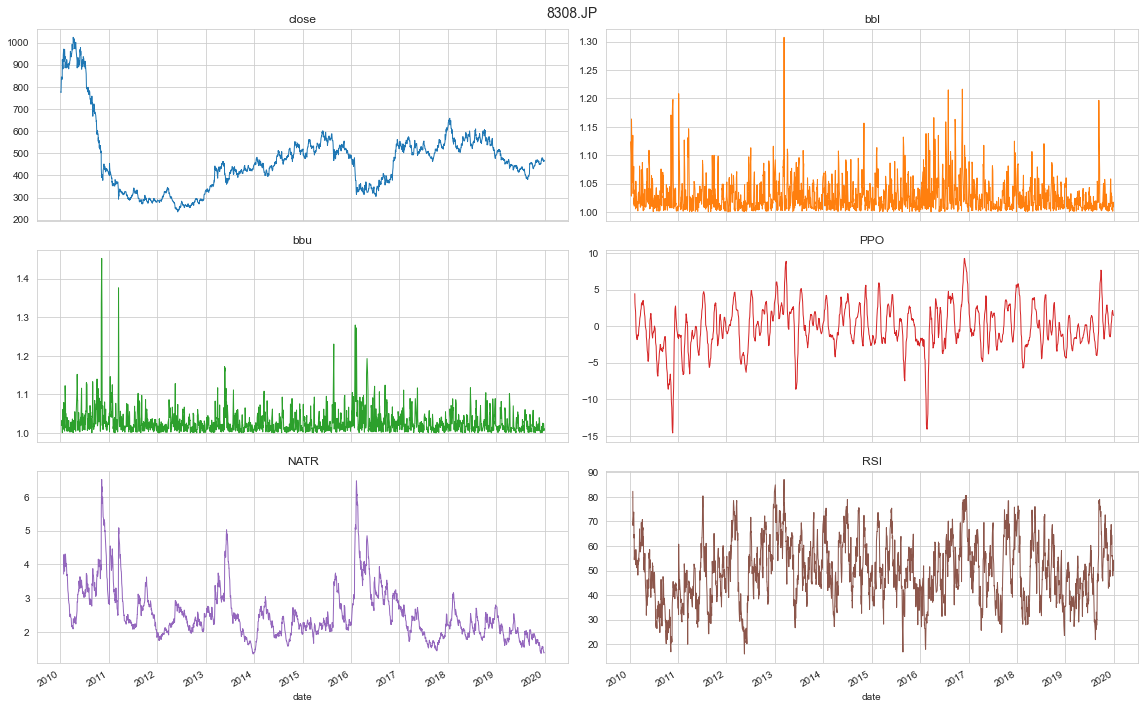

In [41]:
indicators = ['close', 'bbl', 'bbu', 'PPO', 'NATR', 'RSI']
ticker = np.random.choice(data.index.get_level_values('ticker'))
(data.loc[idx[ticker, :], indicators].reset_index('ticker', drop=True)
 .plot(lw=1, subplots=True, figsize=(16, 10), title=indicators, layout=(3, 2), legend=False))
plt.suptitle(ticker, fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.95)

In [32]:
data = data.drop(prices.columns, axis=1)

### Create time period indicators

In [33]:
dates = data.index.get_level_values('date')
data['weekday'] = dates.weekday
data['month'] = dates.month
data['year'] = dates.year

## Compute forward returns

In [34]:
outcomes = []
by_ticker = data.groupby('ticker')
for t in intervals:
    k = f'fwd_ret_{t:02}'
    outcomes.append(k)
    data[k] = by_ticker[f'ret_{t}'].shift(-t)

In [35]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2304509 entries, ('1332.JP', Timestamp('2010-01-04 00:00:00')) to ('9990.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   ret_1            2303568 non-null  float64
 1   ret_rel_perc_1   2303568 non-null  float64
 2   ret_5            2299804 non-null  float64
 3   ret_rel_perc_5   2299804 non-null  float64
 4   ret_10           2295099 non-null  float64
 5   ret_rel_perc_10  2295099 non-null  float64
 6   ret_21           2284748 non-null  float64
 7   ret_rel_perc_21  2284748 non-null  float64
 8   ret_63           2245226 non-null  float64
 9   ret_rel_perc_63  2245226 non-null  float64
 10  PPO              2280984 non-null  float64
 11  NATR             2291335 non-null  float64
 12  RSI              2291335 non-null  float64
 13  bbl              2300745 non-null  float64
 14  bbu              2300745 non-nul

In [36]:
data.to_hdf('data.h5', 'stooq/japan/equities')